<a href="https://colab.research.google.com/github/jamc88/Signal-Detection-in-FAERS-Pharmacovigilance/blob/main/An%C3%A1lisis_Datos_q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

In [8]:
#Montamos el drive
drive.mount('/content/drive', force_remount=True)
base_path = Path("/content/drive/MyDrive/Proyecto_Terminal_2/Datos_Q3")


Mounted at /content/drive


In [10]:
base = Path("/content/drive/MyDrive/Proyecto_Terminal_2/Datos_Q3") #ruta
# Leemos asegurando que el ID sea texto (string)
reports = pd.read_csv(base/"q3_reports_100k.csv", dtype={"safetyreportid":"string"})

drugs = pd.read_csv(base/"q3_drugs_100k.csv", dtype={"safetyreportid":"string"})

reactions = pd.read_csv(base/"q3_reactions_100k.csv", dtype={"safetyreportid":"string"})

#AUDITORÍA
#imprimimos cuántas filas tiene cada archivo
print("filas:", {"reports": len(reports), "drugs": len(drugs), "reactions": len(reactions)})
#contamos cuántos IDs únicos hay (deberían ser 100,000 a fuerza)
print("ID's únicos en los informes:", reports["safetyreportid"].nunique())

#si hay identificadores vacíos (nulos) en cada tabla
print("tasas de identificación nula:", {
    "reports": reports["safetyreportid"].isna().mean(),   # Promedio de nulos en reportes
    "drugs": drugs["safetyreportid"].isna().mean(),       # Promedio de nulos en drogas
    "reactions": reactions["safetyreportid"].isna().mean(), # Promedio de nulos en reacciones
})


# Verificamos si hay drogas cuyo ID no existe en la tabla de reportes (debería ser 0)
print("Medicamentos que no aparecen en los informes:", (~drugs["safetyreportid"].isin(reports["safetyreportid"])).sum())
# Verificamos si hay reacciones cuyo ID no existe en la tabla de reportes igual deben ser 0
print("Reacciones que no aparecen en los informes:", (~reactions["safetyreportid"].isin(reports["safetyreportid"])).sum())

#LIMPIEZA DE STRINGS (TEXTO)
# Normalizamos nombres de medicamentos a mayúsculas y sin espacios extra
for col in ["medicinalproduct", "activesubstancename"]:
    if col in drugs.columns: # Solo si la columna existe
        drugs[col] = drugs[col].astype("string").str.strip().str.upper()

#nombres de las reacciones a mayúsculas
reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

#CREACIÓN DE LLAVE DE MEDICAMENTO
# Creamos una columna 'drug_key': Si hay Ingrediente Activo, usa ese; si no, usa el Nombre Comercial.
drugs["drug_key"] = drugs["activesubstancename"].fillna(drugs["medicinalproduct"]).astype("string").str.strip().str.upper()


# Eliminamos duplicados dentro del mismo reporte (si el mismo ID reporta la misma droga 2 veces, cuenta como 1)
drugs_u = drugs[["safetyreportid","drug_key"]].dropna().drop_duplicates()
# Lo mismo para las reacciones
reac_u  = reactions[["safetyreportid","reaction_pt"]].dropna().drop_duplicates()

# Imprimimos los conteos finales únicos
print("filas de medicamentos únicos:", len(drugs_u))
print("filas de reacción únicas:", len(reac_u))

filas: {'reports': 100000, 'drugs': 508861, 'reactions': 354241}
ID's únicos en los informes: 100000
tasas de identificación nula: {'reports': np.float64(0.0), 'drugs': np.float64(0.0), 'reactions': np.float64(0.0)}
Medicamentos que no aparecen en los informes: 0
Reacciones que no aparecen en los informes: 0
filas de medicamentos únicos: 327496
filas de reacción únicas: 349965


Los números obtenidos revelan la salud digamos de los datos.

Al obtener exactamente 100,000 IDs únicos con una tasa de nulos del 0%, validamos que el proceso de extracción (Reservoir Sampling) funcionó sin errores: no hay id corrptos ni reportes vacío, asegura que cada evento adverso y cada fármaco listado está correctamente vinculado a un paciente específico.


Inicialmente, el sistema cargó 508,861 registros de medicamentos y despues de la limpieza y deduplicación por reporte, la cifra fue a 327,496.

El número 327,496 representa el real, la cantidad verdadera de cosas distintas a las que estuvieron expuestos los pacientes, eliminando el conteo doble que hubiera falseado las estadísticas de frecuencia.

Luego la tabla de reacciones mostró que paso de 354,241 registros crudos a 349,965 únicos, osea muy poco

Esto indica que el campo de eventos adversos suele ser llenado de manera concisa: si un paciente reporta "Dolor de cabeza", lo hace una sola vez,no hay tanta duplicidad como en los fármacos

La limpieza fue necesaria en los fármacos para evitar la inflación de datos.


In [12]:
# Volvemos a definir la base por seguridad como en el orig.
base = Path("/content/drive/MyDrive/Proyecto_Terminal_2/Datos_Q3")

reports = pd.read_csv(base/"q3_reports_100k.csv", dtype={"safetyreportid":"string"})
drugs = pd.read_csv(base/"q3_drugs_100k.csv", dtype={"safetyreportid":"string"})
reactions = pd.read_csv(base/"q3_reactions_100k.csv", dtype={"safetyreportid":"string"})

#LIMPIEZA RÁPIDA
#normalizamos a mayúsculas nuevamente para el conteo
for col in ["medicinalproduct", "activesubstancename"]:
    drugs[col] = drugs[col].astype("string").str.strip().str.upper()
reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

#Seleccionamos columnas clave y quitamos duplicados
drugs_u = drugs[["safetyreportid","activesubstancename","medicinalproduct"]].drop_duplicates()
reac_u  = reactions[["safetyreportid","reaction_pt"]].drop_duplicates()

#agrupamos por ID y contamos el tamaño (cuántos items tiene cada ID)
drugs_per_report = drugs_u.groupby("safetyreportid").size()
reac_per_report  = reac_u.groupby("safetyreportid").size()

# Imprimimos los percentiles para ver la distribución (Mediana, 90%, 99%)
print("Drugs/report percentiles:\n", drugs_per_report.quantile([.5,.75,.9,.95,.99]))
print("Reactions/report percentiles:\n", reac_per_report.quantile([.5,.75,.9,.95,.99]))

Drugs/report percentiles:
 0.50     1.0
0.75     3.0
0.90     8.0
0.95    13.0
0.99    27.0
dtype: float64
Reactions/report percentiles:
 0.50     2.0
0.75     4.0
0.90     7.0
0.95    10.0
0.99    24.0
dtype: float64


Aqui se realiza una deduplicación para contar las únicas; es decir, si un reporte menciona el mismo medicamento tres veces, el código lo reduce a una sola mención para medir la exposición real. Finalmente, mediante la función groupby y quantile, calcula la densidad de información por reporte, dividiendo la población de 100,000 casos en segmentos porcentuales para entender qué tan complejos son los casos reportados en el trimestre.

En cuanto a los medicamentos la mediana (percentil 0.50) se sitúa en 1
"Si ordenamos todos los reportes de menor a mayor, al llegar a la mitad exacta (el 50%), encontramos que ese reporte tiene 1.0 medicamento".

Sin embargo, la distribución crece exponencialmente hacia los extremos; el percentil 95 muestra 13 medicamentos, y el percentil 99 da  27.0 medicamentos por reporte.

Por otro lado, las reacciones adversas muestran una mediana de 2.0, lo que significa que el caso típico describe un cuadro clínico puntual con un par de síntomas.


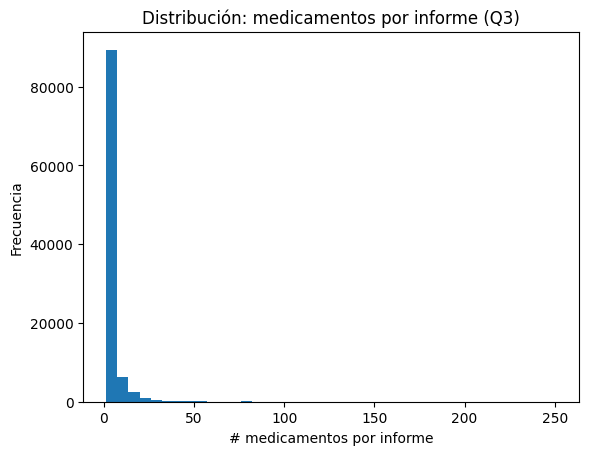

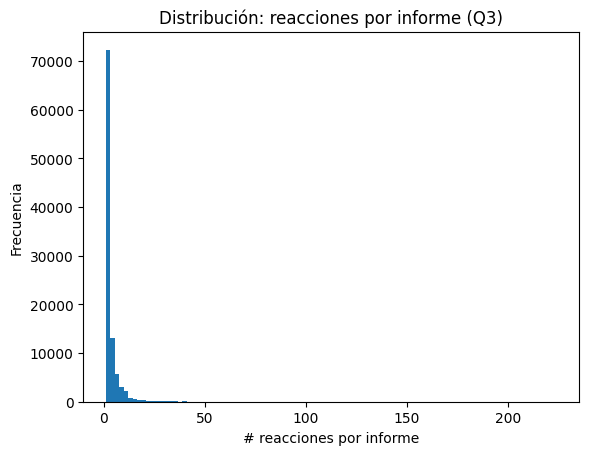

In [20]:
plt.figure()
plt.hist(drugs_per_report, bins=40)              #histograma con 100 barras
plt.xlabel("# medicamentos por informe")
plt.ylabel("Frecuencia")
plt.title("Distribución: medicamentos por informe (Q3)")
#plt.ylim(0,100)                                  # Límite del eje Y
plt.show()

#REACCIONES
plt.figure()
plt.hist(reac_per_report, bins=100)
plt.xlabel("# reacciones por informe")
plt.ylabel("Frecuencia")
#plt.ylim(0,100)
plt.title("Distribución: reacciones por informe (Q3)")
plt.show()

Los datos del Q3 posee una estructura de distribución asimétrica positiva, osea cola larga.
Confirmamos con el percentil 50 o mediana, que muestra que la mitad de la población reportada estuvo expuesta a un único medicamento y manifestó apenas dos reacciones adversas.

In [21]:
#calculamos qué porcentaje tiene nombre de sustancia activa válido (no nulo y largo > 0)
active_nonnull = drugs["activesubstancename"].notna() & (drugs["activesubstancename"].str.len() > 0)
#calculamos qué porcentaje tiene nombre de producto medicinal válido
prod_nonnull   = drugs["medicinalproduct"].notna() & (drugs["medicinalproduct"].str.len() > 0)

#porcentajes de calidad
print("Filas de fracciones con nombre de sustancia activa:", active_nonnull.mean())
print("Filas de fracciones con medicamento:", prod_nonnull.mean())

# Obtenemos el Top 20 de sustancias activas más frecuentes
top_active = drugs.loc[active_nonnull, "activesubstancename"].value_counts().head(20)
# Obtenemos el Top 20 de productos comerciales más frecuentes
top_prod   = drugs.loc[prod_nonnull, "medicinalproduct"].value_counts().head(20)

print("\nTop-20 sustancias activas:")
display(top_active)

print("\nTop-20 productos medicinales:")
display(top_prod)

Filas de fracciones con nombre de sustancia activa: 0.9827497096456597
Filas de fracciones con medicamento: 1.0

Top-20 sustancias activas:


,count
activesubstancename,
TIRZEPATIDE,14891
DUPILUMAB,11487
PREDNISONE,7263
RITUXIMAB,6300
METHOTREXATE,6178
ACETAMINOPHEN,5971
SEMAGLUTIDE,5398
TOCILIZUMAB,5151
VEDOLIZUMAB,5049



Top-20 productos medicinales:


,count
medicinalproduct,
DUPIXENT,11310
MOUNJARO,7487
ZEPBOUND,7322
PREDNISONE,7237
METHOTREXATE,6171
RITUXIMAB,5987
VEDOLIZUMAB,4503
ACTEMRA,4118
ACETAMINOPHEN,3920


Calidad de nombres
Se hace Calidad de nombres para asegurarte de que la “variable fármaco” (D) y, en menor medida, la “variable evento” (A) son comparables y consistentes antes de contar coocurrencias y calcular señales (PRR/ROR/IC).

En FAERS los nombres vienen con variaciones (marca vs genérico, mayúsculas, espacios, abreviaturas, “UNKNOWN”, etc.). Si no se revisa esto, se puede terminar contando como distintos lo que es lo mismo, o mezclando basura con datos reales.


Top-20 reacciones (PT):


,count
reaction_pt,
OFF LABEL USE,7256
DRUG INEFFECTIVE,5538
FATIGUE,4960
DEATH,4341
NAUSEA,4315
DIARRHOEA,4049
PRODUCT DOSE OMISSION ISSUE,3686
HEADACHE,3293
PAIN,2972


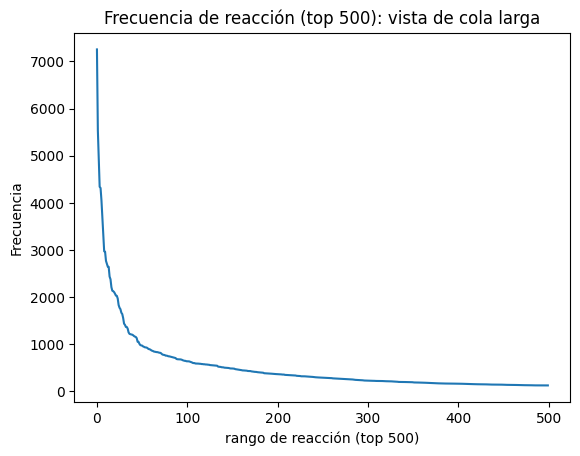

In [23]:
#frecuencia de cada reacción adversa
top_reac = reactions["reaction_pt"].value_counts()

# Mostramos el Top 20
print("\nTop-20 reacciones (PT):")
display(top_reac.head(20))

#gráfica de línea de la "Cola Larga" (primeras 500 reac)
plt.figure()
plt.plot(top_reac.values[:500])                   # Grafica los valores
plt.xlabel("rango de reacción (top 500)")         # Eje X
plt.ylabel("Frecuencia")                          # Eje Y
plt.title("Frecuencia de reacción (top 500): vista de cola larga") # Título
plt.show()

Se hace frecuencia y cola larga para entender cómo están distribuidos los eventos (y fármacos) y cómo eso afecta la confiabilidad de las señales.

En FAERS casi siempre pasa esto: pocos términos aparecen muchísimo y muchísimos términos aparecen muy poco. Eso es la “cola larga”.


La gráfica nos da una representación del comportamiento de los eventos reportados en el tercer trimestre. L curva nod dice que  (aproximadamente las primeras 20 a 50) concentra una frecuencia de reporte superando las 7,000 a esa región en especifico se le conoce como la "cabeza" de la distribución suelen incluir tanto síntomas clínicos como fatiga o náusea como términos administrativos o de calidad del producto.

A medida que avanzamos en el eje X hacia el rango 100-200, la curva experimenta una desaceleración , aplanándose
Para cuando llegamos al rango 300-500, la frecuencia de reporte cae a unos pocos cientos de casos por reacción, esta sección extendida y casi horizontal conforma la "cola larga" de la distribución.
Esto indica que, aunque existen miles de tipos diferentes de reacciones adversas posibles, la gran mayoría de ellas ocurren con muy baja frecuencia en la población


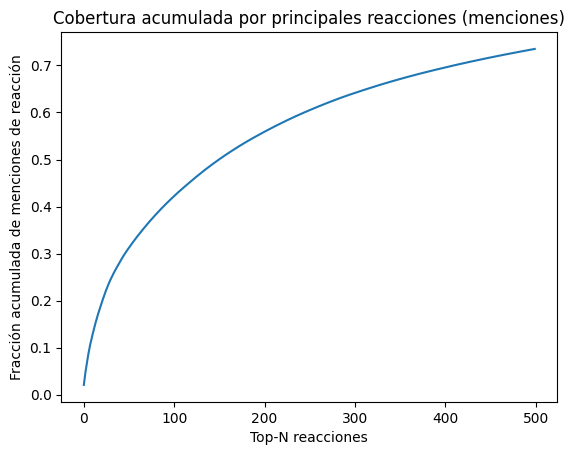

In [24]:
#suma acumulada para ver qué % del total cubren las top N reacciones
cum = top_reac.cumsum() / top_reac.sum()

# Generamos la gráfica
plt.figure()
plt.plot(cum.values[:500])                        # Grafica la curva acumulada
plt.xlabel("Top-N reacciones")                    # Eje X
plt.ylabel("Fracción acumulada de menciones de reacción") # Eje Y
plt.title("Cobertura acumulada por principales reacciones (menciones)") # Título
plt.show()

La gráfica de cobertura acumulada complementa la distribución de frecuencia, permitiéndonos cuantificar qué proporción del volumen total de información está contenida en las reacciones más comunes.
La curva asciende rápidamente en el eje Y con un número relativamente pequeño de reacciones en el eje X, específicamente, se observa que las Top-500 reacciones logran cubrir aproximadamente arriba del 70% del total de menciones registradas en la base de datos del Q3.

 Significa que al enfocar el análisis en estos términos frecuentes, se está capturando la inmensa mayoría de la evidencia disponible. Por otro lado, la existencia de ese 25% aprox residual disperso justifica plenamente la implementación de umbrales mínimos de soporte como exigir al menos 3 o 5 casos para considerar una señal.


Top-10 occurcountry:


,count
occurcountry,
US,62072
EU,10782
CA,6350
JP,4165
GB,3727
CN,2455
AU,755
BR,719
IN,657



Parsed receiptdate valid fraction: 1.0


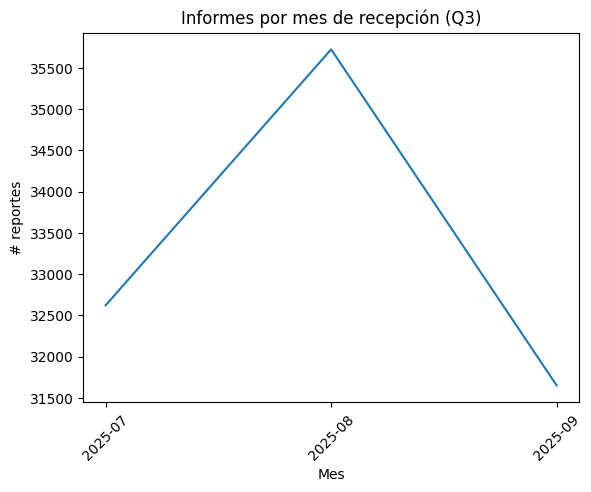

In [26]:
#PAÍSES
if "occurcountry" in reports.columns:             # Si la columna existe
    print("\nTop-10 occurcountry:")               #imprime título
    # Muestra los 10 países más frecuentes
    display(reports["occurcountry"].astype("string").str.strip().str.upper().value_counts().head(10))

#FECHAS (RECEIPTDATE)
if "receiptdate" in reports.columns:              # Si la columna existe...
    r = reports["receiptdate"].astype("string").str.strip() # Limpia espacios
    #formato AñoMesDia
    dt = pd.to_datetime(r, format="%Y%m%d", errors="coerce")

    # Imprime qué porcentaje de fechas son válidas
    print("\nParsed receiptdate valid fraction:", dt.notna().mean())

    # Si hay fechas válidas, grafica la evolución por mes
    if dt.notna().any():
        # Agrupa por mes y cuenta
        counts = dt.dt.to_period("M").value_counts().sort_index()

        plt.figure()
        plt.plot(counts.index.astype(str), counts.values) # Grafica línea temporal
        plt.xlabel("Mes")
        plt.ylabel("# reportes")
        plt.title("Informes por mes de recepción (Q3)")
        plt.xticks(rotation=45)                   # Rota las etiquetas del eje X para que se lean mejor
        plt.show()

inicia con una cifra en julio (aproximadamente 32,600 reportes), experimenta un pico notable en agosto superando los 35,500 casos, y desciende hacia septiembre cerca de los 31,600. Este comportamiento de  fluctuación mensual es habitual en sistemas de farmacovigilancia

La lista de los 10 principales países emisores muestra un dominio de Estados Unidos, que por sí solo aporta más de 61,000 reportes, representando más del 60% de la muestra total. Le siguen, con una diferencia considerable, países como Canadá, Japón, Francia y Gran Bretaña. Esta asimetría geográfica tiene implicaciones científicas directas, cualquier señal de seguridad detectada en este análisis estará fuertemente influenciada por los patrones como la genética y el sistema estadounidense.

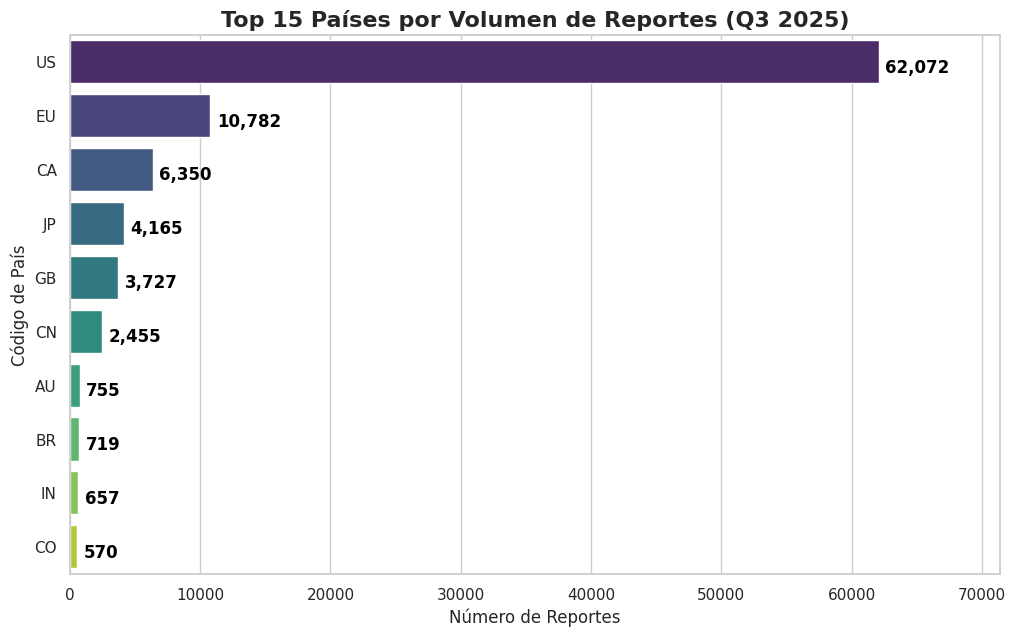

In [38]:
import seaborn as sns

#tomo top 10 para no saturar
if "occurcountry" in reports.columns:
    country_counts = reports["occurcountry"].astype("string").str.strip().str.upper().value_counts().reset_index()
    country_counts.columns = ["País", "Reportes"]
    top_countries = country_counts.head(10)


    plt.figure(figsize=(12, 7))

    #usamos Seaborn
    sns.set_theme(style="whitegrid")
    barplot = sns.barplot(data=top_countries, x="Reportes", y="País",
                          palette="viridis", hue="País", legend=False)

    # Añadimos los números al final de cada barra (para que se lea mas fácil)
    for i, p in enumerate(barplot.patches):
        width = p.get_width()
        plt.text(width + 500,
                 p.get_y() + p.get_height()/2 + 0.1,
                 '{:,.0f}'.format(width), # Formato del número (con comas)
                 ha="left", va="center", fontweight='bold', color='black')

    plt.title("Top 15 Países por Volumen de Reportes (Q3 2025)", fontsize=16, fontweight='bold')
    plt.xlabel("Número de Reportes", fontsize=12)
    plt.ylabel("Código de País", fontsize=12)
    plt.xlim(0, top_countries["Reportes"].max() * 1.15) # Dar espacio extra
    plt.show()

else:
    print("No se encontró la columna 'occurcountry' en el archivo.")